In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class DifferentialDNN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[64, 64], alpha=0.5):
        super().__init__()
        self.alpha = alpha
        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    def compute_jacobian(self, outputs, inputs, n):
        """
        outputs: (batch, p)
        inputs: (batch, n + m), requires_grad=True
        Returns: (batch, p, n)
        """
        inputs_n = inputs[:, :n]
        batch_size, p = outputs.shape
        jac = []
        for i in range(p):
            grad = torch.autograd.grad(
                outputs[:, i], inputs_n,
                grad_outputs=torch.ones_like(outputs[:, i]),
                retain_graph=True, create_graph=True,
                allow_unused=True
            )[0]
            if grad is None:
                grad = torch.zeros_like(inputs_n)
            jac.append(grad.unsqueeze(1))  # (batch, 1, n)
        return torch.cat(jac, dim=1)  # (batch, p, n)

    def differential_loss(self, y_pred, y_true, j_pred, j_true):
        value_loss = F.mse_loss(y_pred, y_true)
        jacobian_loss = F.mse_loss(j_pred, j_true)
        return self.alpha * value_loss + (1 - self.alpha) * jacobian_loss

    def fit(self, x, y, j, n, epochs=100, batch_size=64, lr=1e-3):
        self.train()
        dataset = TensorDataset(x, y, j)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            total_loss = 0.0
            for xb, yb, jb in loader:
                xb = xb.requires_grad_()  # important for autograd
                optimizer.zero_grad()
                y_pred = self.forward(xb)
                j_pred = self.compute_jacobian(y_pred, xb, n)
                loss = self.differential_loss(y_pred, yb, j_pred, jb)
                loss.backward()
                optimizer.step()
                total_loss += loss.item() * xb.size(0)
            avg_loss = total_loss / len(dataset)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}")

    def predict(self, x, n):
        self.eval()
        x = x.clone().detach().requires_grad_()
        y_pred = self.forward(x)
        j_pred = self.compute_jacobian(y_pred, x, n)
        return y_pred.detach(), j_pred.detach()


In [ ]:
# Dimensions
N, n, m, p = 500, 24, 5, 10

# Synthetic data where outputs depend on differentiable inputs
x_train = torch.randn(N, n + m)
y_train = torch.sin(x_train[:, :p]) + 0.1 * torch.randn(N, p)
j = torch.zeros(N, p, n)
for i in range(p):
    for j_idx in range(n):
        j[:, i, j_idx] = torch.cos(x_train[:, j_idx]) if j_idx < p else 0.0

model = DifferentialDNN(input_dim=n + m, output_dim=p, alpha=0.5)
model.fit(x_train, y_train, j, n=n, epochs=5, batch_size=32)

x_test = torch.randn(10, n + m)
y_pred, j_pred = model.predict(x_test, n=n)


Epoch 1/5, Loss: 0.335422
Epoch 2/5, Loss: 0.311276
Epoch 3/5, Loss: 0.286509
Epoch 4/5, Loss: 0.257233
Epoch 5/5, Loss: 0.227243


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

class DifferentialDNN2(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[64, 64], alpha=0.5, scaling=True):
        super().__init__()
        self.alpha = alpha
        self.scaling = scaling

        layers = []
        dims = [input_dim] + hidden_dims
        for i in range(len(dims) - 1):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(dims[-1], output_dim))
        self.net = nn.Sequential(*layers)

        # Will be set during fit()
        self.n = None
        self.input_mean = None
        self.input_std = None
        self.output_mean = None
        self.output_std = None
        self.jacobian_scale = None  # To scale jacobian rows appropriately

    def forward(self, x):
        return self.net(x)

    # --- Scaling methods ---

    def _scale_inputs(self, x):
        if not self.scaling or self.input_mean is None:
            return x
        return (x - self.input_mean) / self.input_std

    def _unscale_outputs(self, y_scaled):
        if not self.scaling or self.output_mean is None:
            return y_scaled
        return y_scaled * self.output_std + self.output_mean

    def _scale_jacobians(self, j_raw):
        if not self.scaling or self.input_std is None or self.output_std is None:
            return j_raw
        input_std_n = self.input_std[:self.n]  # only first n inputs
        scale = (input_std_n.view(1, 1, -1) / self.output_std.view(1, -1, 1))
        return j_raw * scale

    def _unscale_jacobians(self, j_scaled):
        if not self.scaling or self.input_std is None or self.output_std is None:
            return j_scaled
        input_std_n = self.input_std[:self.n]
        scale = (self.output_std.view(-1, 1) / input_std_n.view(1, -1))
        return j_scaled * scale

    # --- Jacobian computation with allow_unused fix ---

    def compute_jacobian(self, outputs, inputs, n):
        inputs_n = inputs[:, :n]
        batch_size, p = outputs.shape
        jac = []
        for i in range(p):
            grad = torch.autograd.grad(
                outputs[:, i], inputs_n,
                grad_outputs=torch.ones_like(outputs[:, i]),
                retain_graph=True, create_graph=True,
                allow_unused=True
            )[0]
            if grad is None:
                grad = torch.zeros_like(inputs_n)
            jac.append(grad.unsqueeze(1))
        return torch.cat(jac, dim=1)

    def differential_loss(self, y_pred, y_true, j_pred, j_true):
        value_loss = F.mse_loss(y_pred, y_true)
        jacobian_loss = F.mse_loss(j_pred, j_true)
        return self.alpha * value_loss + (1 - self.alpha) * jacobian_loss

    # --- Fit and Predict ---

    def fit(self, x, y, j, n, epochs=100, batch_size=64, lr=1e-3):
        """
        x: (N, n + m) raw inputs
        y: (N, p) raw outputs
        j: (N, p, n) raw Jacobians
        n: number of differentiable inputs
        """
        self.train()
        self.n = n

        # Compute scaling params if scaling enabled
        if self.scaling:
            self.input_mean = x.mean(dim=0, keepdim=True)
            self.input_std = x.std(dim=0, unbiased=False, keepdim=True).clamp(min=1e-6)
            self.output_mean = y.mean(dim=0, keepdim=True)
            self.output_std = y.std(dim=0, unbiased=False, keepdim=True).clamp(min=1e-6)

            # flatten for jacobian scaling (p, n)
            self.input_std = self.input_std.view(-1)
            self.output_std = self.output_std.view(-1)

            # scale training data
            x_scaled = self._scale_inputs(x)
            y_scaled = (y - self.output_mean) / self.output_std
            j_scaled = self._scale_jacobians(j)
        else:
            x_scaled, y_scaled, j_scaled = x, y, j

        dataset = TensorDataset(x_scaled, y_scaled, j_scaled)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            total_loss = 0.0
            for xb, yb, jb in loader:
                xb = xb.requires_grad_()
                optimizer.zero_grad()
                y_pred = self.forward(xb)
                j_pred = self.compute_jacobian(y_pred, xb, n)
                loss = self.differential_loss(y_pred, yb, j_pred, jb)
                loss.backward(retain_graph=True)
                optimizer.step()
                total_loss += loss.item() * xb.size(0)
            avg_loss = total_loss / len(dataset)
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {avg_loss:.6f}")

    def predict(self, x, n):
        """
        x: raw inputs (batch, n+m)
        returns: unscaled outputs and jacobians
        """
        self.eval()
        # scale inputs if needed
        x_scaled = self._scale_inputs(x) if self.scaling else x
        x_scaled = x_scaled.clone().detach().requires_grad_()
        y_pred = self.forward(x_scaled)
        j_pred = self.compute_jacobian(y_pred, x_scaled, n)

        # unscale outputs and jacobians
        y_pred_unscaled = self._unscale_outputs(y_pred) if self.scaling else y_pred
        j_pred_unscaled = self._unscale_jacobians(j_pred) if self.scaling else j_pred

        return y_pred_unscaled.detach(), j_pred_unscaled.detach()


In [6]:
n, m, p = 24, 0, 10
N = 500
x_train = torch.randn(N, n + m)
x_train.requires_grad_(True)  # Important for autograd
c = torch.randn(n+m, p)  # Coefficients for linear combination

#y = torch.randn(N, p)

def fun(x):
    return x @ c

y_train = fun(x_train)

jacobians = []
for i in range(y_train.shape[1]):  # For each output dimension
    grads = torch.autograd.grad(
        y_train[:, i], x_train,
        grad_outputs=torch.ones_like(y_train[:, i]),
        retain_graph=True, create_graph=True
    )[0]  # (N, n+m)
    jacobians.append(grads.unsqueeze(1))  # (N, 1, n+m)
jacobian_train= torch.cat(jacobians, dim=1)  # (N, p, n+m)


In [20]:
model = DifferentialDNN2(input_dim=n + m, output_dim=p, alpha=0.5, scaling=True,hidden_dims=[64, 64,64])


In [24]:

model.fit(x_train, y_train, jacobian_train, n=n, epochs=20, batch_size=32)

x_test = torch.randn(100, n + m)
y_pred, j_pred = model.predict(x_test, n=n)


Epoch 1/20, Loss: 0.026057
Epoch 2/20, Loss: 0.023166
Epoch 3/20, Loss: 0.022715
Epoch 4/20, Loss: 0.022529
Epoch 5/20, Loss: 0.022548
Epoch 6/20, Loss: 0.022547
Epoch 7/20, Loss: 0.022461
Epoch 8/20, Loss: 0.022417
Epoch 9/20, Loss: 0.022395
Epoch 10/20, Loss: 0.022483
Epoch 11/20, Loss: 0.022382
Epoch 12/20, Loss: 0.022316
Epoch 13/20, Loss: 0.022265
Epoch 14/20, Loss: 0.022280
Epoch 15/20, Loss: 0.022287
Epoch 16/20, Loss: 0.022252
Epoch 17/20, Loss: 0.022240
Epoch 18/20, Loss: 0.022291
Epoch 19/20, Loss: 0.022206
Epoch 20/20, Loss: 0.022201


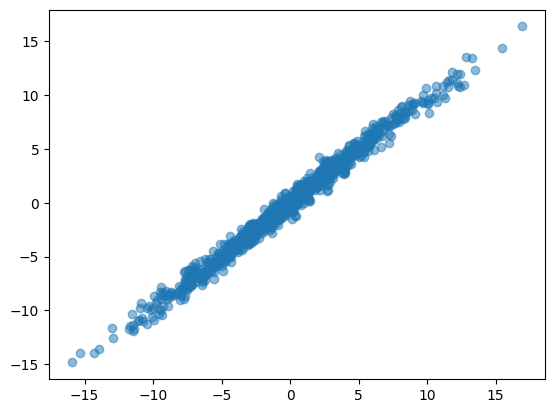

In [25]:
import matplotlib.pyplot as plt
plt.plot(fun(x_test).ravel(),y_pred.ravel(), 'o', alpha=0.5)